In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import argparse
import os

from azureml.core.run import Run
from azureml.core import Workspace, Dataset
from tf_agents.environments import tf_py_environment, py_environment, utils
from tf_agents.networks import sequential
from tf_agents.agents.dqn import dqn_agent
from tf_agents.policies import EpsilonGreedyPolicy, random_tf_policy, tf_policy, tf_py_policy, py_policy
from tf_agents.policies.q_policy import QPolicy
from tf_agents.policies.boltzmann_policy import BoltzmannPolicy
from tf_agents.trajectories import trajectory, Trajectory, PolicyStep, time_step as ts
from tf_agents.replay_buffers import TFUniformReplayBuffer
from tf_agents.metrics import tf_metrics
from tf_agents.specs import array_spec
from tf_agents.drivers import dynamic_step_driver
from tf_agents.utils import common
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout
from helper_functions import *
from environment_functions import *

In [2]:
class DynamicPricingCompetition():
    
    """
    A game object where the agent can interact with and that we can update remotely
    to adjust the current state based on recent observations.
    This class also keeps track of all the steps and rewards that took place for later analysis.
    """
    
    def __init__(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
        self.demand_competitor_t1 = 1
        self.demand_competitor_t2 = 1
        self.demand_competitor_t3 = 1
        self.demand_competitor_t4 = 1
        self.demand_competitor_t5 = 1
        self.demand_competitor_t6 = 1
        self.demand_competitor_t7 = 1
        self.demand_competitor_t8 = 1
        self.demand_competitor_t9 = 1
        self.demand_competitor_t10 = 1
        self.competition_results_df = pd.DataFrame(columns=[
            'our_strategy',
            'competition_id',
            'selling_season', 
            'selling_period', 
            'competitor_id', 
            'price_competitor', 
            'price', 
            'demand', 
            'competitor_has_capacity', 
            'revenue'
        ])
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def reset(self):
        self.selling_period = 1
        self.loadfactor = 0
        self.comp_loadfactor = 0
        self.competitor_has_capacity = 1
        self.price_competitor_t1 = 50
        self.price_competitor_t2 = 50
        self.price_competitor_t3 = 50
        self.price_competitor_t4 = 50
        self.price_competitor_t5 = 50
        self.price_competitor_t6 = 50
        self.price_competitor_t7 = 50
        self.price_competitor_t8 = 50
        self.price_competitor_t9 = 50
        self.price_competitor_t10 = 50
        self.price_t1 = 50
        self.price_t2 = 50
        self.price_t3 = 50
        self.price_t4 = 50
        self.price_t5 = 50
        self.price_t6 = 50
        self.price_t7 = 50
        self.price_t8 = 50
        self.price_t9 = 50
        self.price_t10 = 50
        self.demand_t1 = 1
        self.demand_t2 = 1
        self.demand_t3 = 1
        self.demand_t4 = 1
        self.demand_t5 = 1
        self.demand_t6 = 1
        self.demand_t7 = 1
        self.demand_t8 = 1
        self.demand_t9 = 1
        self.demand_t10 = 1
        self.demand_competitor_t1 = 1
        self.demand_competitor_t2 = 1
        self.demand_competitor_t3 = 1
        self.demand_competitor_t4 = 1
        self.demand_competitor_t5 = 1
        self.demand_competitor_t6 = 1
        self.demand_competitor_t7 = 1
        self.demand_competitor_t8 = 1
        self.demand_competitor_t9 = 1
        self.demand_competitor_t10 = 1
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_state(self, vars_dict):
        self.selling_period = vars_dict['selling_period']
        self.loadfactor = vars_dict['loadfactor']
        self.comp_loadfactor = vars_dict['comp_loadfactor']
        self.competitor_has_capacity = vars_dict['competitor_has_capacity']
        self.price_competitor_t1 = vars_dict['price_competitor_t-1']
        self.price_competitor_t2 = vars_dict['price_competitor_t-2']
        self.price_competitor_t3 = vars_dict['price_competitor_t-3']
        self.price_competitor_t4 = vars_dict['price_competitor_t-4']
        self.price_competitor_t5 = vars_dict['price_competitor_t-5']
        self.price_competitor_t6 = vars_dict['price_competitor_t-6']
        self.price_competitor_t7 = vars_dict['price_competitor_t-7']
        self.price_competitor_t8 = vars_dict['price_competitor_t-8']
        self.price_competitor_t9 = vars_dict['price_competitor_t-9']
        self.price_competitor_t10 = vars_dict['price_competitor_t-10']
        self.price_t1 = vars_dict['price_t-1']
        self.price_t2 = vars_dict['price_t-2']
        self.price_t3 = vars_dict['price_t-3']
        self.price_t4 = vars_dict['price_t-4']
        self.price_t5 = vars_dict['price_t-5']
        self.price_t6 = vars_dict['price_t-6']
        self.price_t7 = vars_dict['price_t-7']
        self.price_t8 = vars_dict['price_t-8']
        self.price_t9 = vars_dict['price_t-9']
        self.price_t10 = vars_dict['price_t-10']
        self.demand_t1 = vars_dict['demand_t-1']
        self.demand_t2 = vars_dict['demand_t-2']
        self.demand_t3 = vars_dict['demand_t-3']
        self.demand_t4 = vars_dict['demand_t-4']
        self.demand_t5 = vars_dict['demand_t-5']
        self.demand_t6 = vars_dict['demand_t-6']
        self.demand_t7 = vars_dict['demand_t-7']
        self.demand_t8 = vars_dict['demand_t-8']
        self.demand_t9 = vars_dict['demand_t-9']
        self.demand_t10 = vars_dict['demand_t-10']
        self.demand_competitor_t1 = vars_dict['demand_competitor_t-1']
        self.demand_competitor_t2 = vars_dict['demand_competitor_t-2']
        self.demand_competitor_t3 = vars_dict['demand_competitor_t-3']
        self.demand_competitor_t4 = vars_dict['demand_competitor_t-4']
        self.demand_competitor_t5 = vars_dict['demand_competitor_t-5']
        self.demand_competitor_t6 = vars_dict['demand_competitor_t-6']
        self.demand_competitor_t7 = vars_dict['demand_competitor_t-7']
        self.demand_competitor_t8 = vars_dict['demand_competitor_t-8']
        self.demand_competitor_t9 = vars_dict['demand_competitor_t-9']
        self.demand_competitor_t10 = vars_dict['demand_competitor_t-10']
        
        self.state = [
            self.selling_period,
            self.loadfactor,
            self.comp_loadfactor,
            self.competitor_has_capacity,
            self.price_competitor_t1,
            self.price_competitor_t2,
            self.price_competitor_t3,
            self.price_competitor_t4,
            self.price_competitor_t5,
            self.price_competitor_t6,
            self.price_competitor_t7,
            self.price_competitor_t8,
            self.price_competitor_t9,
            self.price_competitor_t10,
            self.price_t1,
            self.price_t2,
            self.price_t3,
            self.price_t4,
            self.price_t5,
            self.price_t6,
            self.price_t7,
            self.price_t8,
            self.price_t9,
            self.price_t10,
            self.demand_t1,
            self.demand_t2,
            self.demand_t3,
            self.demand_t4,
            self.demand_t5,
            self.demand_t6,
            self.demand_t7,
            self.demand_t8,
            self.demand_t9,
            self.demand_t10,
            self.demand_competitor_t1,
            self.demand_competitor_t2,
            self.demand_competitor_t3,
            self.demand_competitor_t4,
            self.demand_competitor_t5,
            self.demand_competitor_t6,
            self.demand_competitor_t7,
            self.demand_competitor_t8,
            self.demand_competitor_t9,
            self.demand_competitor_t10,
        ]
        self._reward = 0
        
    def update_reward(self, reward):
        self.reward = reward

In [3]:
# Environment in which the agent operates in, and is protected from altering
class AirlineEnvironment(py_environment.PyEnvironment):
    
    def __init__(self, dpc_game, simulator, num_features, num_actions, discount, min_action, 
                 action_step, comp_sellout_price, early_termination_penalty=0, price_diff_penalty=0, 
                 loadactor_diff_penalty=0, stock_remainder_penalty=0):
        """
        Initialize what actions the agent can take,
        and what the observation space will look like.
        
        Also initialize the environment where the agent will interact with.
        """
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=num_actions-1, name='action'
        )
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(num_features,), dtype=np.int32, name='observation'
        )
        self._selling_season = 1
        self._episode_ended = False
        self._discount = discount
        self._dpc_game = dpc_game
        self._simulator = simulator
        self._comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._min_action = min_action
        self._action_step = action_step
        self._comp_sellout_price = comp_sellout_price
        self._early_termination_penalty = early_termination_penalty
        self._price_diff_penalty = price_diff_penalty
        self._loadactor_diff_penalty = loadactor_diff_penalty
        self._stock_remainder_penalty = stock_remainder_penalty
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec
    
    def current_time_step(self):
        return self._current_time_step

    def reset(self):
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        self._current_time_step = self._step(action)
        return self._current_time_step

    def _reset(self):
        self._episode_ended = False
        self._selling_season += 1
        self._dpc_game.reset()
        self._simulator.reset_environment()
        self._comp_strat = np.random.choice(
            a=["random_ranges", "highstart_randomranges", "follower_strategy", "fixed_price", "linear_increase", "random_curve"],
            p=[0.05, 0.05, 0.1, 0.2, 0.3, 0.3]
        )
        self._comp_strategy = CompStrategySimulation(self._comp_strat)
        self._our_price = 50
        self._comp_price = 50
        self._last_comp_price = [0]
        self._all_demand = []
        return ts.restart(np.array(self._dpc_game.state, dtype=np.int32))

    def _step(self, action):
        
#         print(f'Taking step in selling period: {self._dpc_game.selling_period}')
#         print(f'State variables used to make a step are: \n{self._dpc_game.state}')
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start a new episode.
            return self.reset()
        
        if self._dpc_game.state[0] == 1:
            last_price = 50
        else:
            last_price = self._our_price
        
        # Have the policy take one action step
        action = action.item()
        self._our_price = self._min_action + self._action_step*int(action)
        
#         print(f'Action retrieved from policy: {action}, price set to: {self._our_price}')
            
        # Let competitor take a step
        self._comp_price = self._comp_strategy.pick_pricepoint(last_comp_price=self._last_comp_price)
        
#         print(f'Competitor will set price set to: {self._comp_price}')
        
        if self._simulator.comp_stock <= 0:
            self._comp_price = self._comp_sellout_price
#             print(f'Price of competitor is set to {self._comp_sellout_price}, because it no longer has stock.')
            
        # Run a step in the simulation
        log_period = self._simulator.period
        log_comp_stock = self._simulator.comp_stock > 0
        
        self._our_demand, self._comp_demand = self._simulator.simulate_demand(
            our_price=self._our_price, comp_price=self._comp_price)
        
#         print(f'prices returned demand: {self._our_demand}, and competitor demand: {self._comp_demand}')
        
        self._reward = self._our_demand[0] * self._our_price
        
#         print(f'This results in {self._reward} direct revenue')
        
        add_row = {
            'our_strategy': 'dqnagent',
            'competition_id': 'dqnagent' + str(self._selling_season),
            'selling_season': self._selling_season, 
            'selling_period': log_period, 
            'competitor_id': self._comp_strat, 
            'price_competitor': self._comp_price, 
            'price': self._our_price, 
            'demand': self._our_demand[0], 
            'competitor_has_capacity': log_comp_stock, 
            'revenue': self._reward
        }

        self._dpc_game.competition_results_df = self._dpc_game.competition_results_df.append(add_row, ignore_index=True)
        
        # Update states
        vars_dict = {
            'selling_period': self._simulator.period,
            'loadfactor': 80 - self._simulator.our_stock,
            'comp_loadfactor': 80 - self._simulator.comp_stock,
            'competitor_has_capacity': self._simulator.comp_stock > 0,
            'price_competitor_t-1': self._comp_price,
            'price_competitor_t-2': self._dpc_game.price_competitor_t1,
            'price_competitor_t-3': self._dpc_game.price_competitor_t2,
            'price_competitor_t-4': self._dpc_game.price_competitor_t3,
            'price_competitor_t-5': self._dpc_game.price_competitor_t4,
            'price_competitor_t-6': self._dpc_game.price_competitor_t5,
            'price_competitor_t-7': self._dpc_game.price_competitor_t6,
            'price_competitor_t-8': self._dpc_game.price_competitor_t7,
            'price_competitor_t-9': self._dpc_game.price_competitor_t8,
            'price_competitor_t-10': self._dpc_game.price_competitor_t9,
            'price_t-1': self._our_price,
            'price_t-2': self._dpc_game.price_t1,
            'price_t-3': self._dpc_game.price_t2,
            'price_t-4': self._dpc_game.price_t3,
            'price_t-5': self._dpc_game.price_t4,
            'price_t-6': self._dpc_game.price_t5,
            'price_t-7': self._dpc_game.price_t6,
            'price_t-8': self._dpc_game.price_t7,
            'price_t-9': self._dpc_game.price_t8,
            'price_t-10': self._dpc_game.price_t9,
            'demand_t-1': self._our_demand[0],
            'demand_t-2': self._dpc_game.demand_t1,
            'demand_t-3': self._dpc_game.demand_t2,
            'demand_t-4': self._dpc_game.demand_t3,
            'demand_t-5': self._dpc_game.demand_t4,
            'demand_t-6': self._dpc_game.demand_t5,
            'demand_t-7': self._dpc_game.demand_t6,
            'demand_t-8': self._dpc_game.demand_t7,
            'demand_t-9': self._dpc_game.demand_t8,
            'demand_t-10': self._dpc_game.demand_t9,
            'demand_competitor_t-1': self._comp_demand[0],
            'demand_competitor_t-2': self._dpc_game.demand_competitor_t1,
            'demand_competitor_t-3': self._dpc_game.demand_competitor_t2,
            'demand_competitor_t-4': self._dpc_game.demand_competitor_t3,
            'demand_competitor_t-5': self._dpc_game.demand_competitor_t4,
            'demand_competitor_t-6': self._dpc_game.demand_competitor_t5,
            'demand_competitor_t-7': self._dpc_game.demand_competitor_t6,
            'demand_competitor_t-8': self._dpc_game.demand_competitor_t7,
            'demand_competitor_t-9': self._dpc_game.demand_competitor_t8,
            'demand_competitor_t-10': self._dpc_game.demand_competitor_t9,
        }
        
        self._dpc_game.update_state(vars_dict)
        self._dpc_game.update_reward(self._reward)
        
        # Save step and action for the next round
        self._last_comp_price = self._our_price  # Is used in comp strategy, therefore comp price is our price
        self._all_demand.append(self._our_demand[0])
        
        # Make sure episodes don't go on forever.
        if self._dpc_game.state[0] == 100:
            # Add additional penalty for ending the season with high stock left
            self._episode_ended = True
#             print('Season finished')
#             print(f'Stock remainder penalty is set to: {self._stock_remainder_penalty}')
#             print('{} stock left, results in a penalty of: {}'.format(
#                 self._simulator.our_stock, self._stock_remainder_penalty * self._simulator.our_stock))
#             print('Reward for final step in this episode: {}'.format(
#                 self._reward - self._stock_remainder_penalty * self._simulator.our_stock))
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._stock_remainder_penalty * self._simulator.our_stock
            )
        elif self._dpc_game.loadfactor >= 80:
#             print('Season finished early, all stock is sold out.')
#             print(f'Early termination penalty is set to {self._early_termination_penalty} per day')
#             print('There is {} days left, resulting in a penalty of: {}'.format(
#                   100 - self._dpc_game.state[0], self._early_termination_penalty * (100 - self._dpc_game.state[0])))
#             print('Reward for final step in this episode: {}'.format(
#                 self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])))
            # Add additional penalty for ending the season early (higher penalty longer in advance)
            self._episode_ended = True
            return ts.termination(
                np.array(self._dpc_game.state, dtype=np.int32), 
                self._reward - self._early_termination_penalty * (100 - self._dpc_game.state[0])
            )
        else:
            # Add additional penalty for changing prices by a lot
            price_diff_penal = abs(self._our_price - last_price) * self._price_diff_penalty
            # Add additional penaly for selling out too quickly
            load_diff = abs(self._dpc_game.loadfactor - (0.8 * self._dpc_game.state[0]))
            load_diff_penalty = load_diff**2 * self._loadactor_diff_penalty
            
#             print(f'Transitioning to next step')
#             print(f'The penalty for price differences is set to: {self._price_diff_penalty}')
#             print('The price diff is {}, resulting in a penalty of: {}'.format(
#                  abs(self._our_price - last_price), abs(self._our_price - last_price) * self._price_diff_penalty))
#             print(f'Reward for this step: {self._reward - abs(self._our_price - last_price) * self._price_diff_penalty}')
            return ts.transition(
                np.array(self._dpc_game.state, dtype=np.int32), 
                reward=self._reward - price_diff_penal - load_diff_penalty, 
                discount=self._discount
            )

In [25]:
load_diff_penalty = 1
dbd = 50
loadfactor = 40
expected_loadfactor = 0.8 * dbd
load_diff = abs(expected_loadfactor - loadfactor)
penalty = load_diff**2 * load_diff_penalty
print(f'At dbd {dbd} exp. load is {expected_loadfactor}, current load is {loadfactor}')
print(f'Load diff is {load_diff}, penalty is {penalty}')

At dbd 50 exp. load is 40.0, current load is 40
Load diff is 0.0, penalty is 0.0


In [26]:
load_diff_penalty = 1
dbd = 50
loadfactor = 50
expected_loadfactor = 0.8 * dbd
load_diff = abs(expected_loadfactor - loadfactor)
penalty = load_diff**2 * load_diff_penalty
print(f'At dbd {dbd} exp. load is {expected_loadfactor}, current load is {loadfactor}')
print(f'Load diff is {load_diff}, penalty is {penalty}')

At dbd 50 exp. load is 40.0, current load is 50
Load diff is 10.0, penalty is 100.0


In [27]:
load_diff_penalty = 0.5
dbd = 50
loadfactor = 50
expected_loadfactor = 0.8 * dbd
load_diff = abs(expected_loadfactor - loadfactor)
penalty = load_diff**2 * load_diff_penalty
print(f'At dbd {dbd} exp. load is {expected_loadfactor}, current load is {loadfactor}')
print(f'Load diff is {load_diff}, penalty is {penalty}')

At dbd 50 exp. load is 40.0, current load is 50
Load diff is 10.0, penalty is 50.0


In [28]:
load_diff_penalty = 0.5
dbd = 50
loadfactor = 30
expected_loadfactor = 0.8 * dbd
load_diff = abs(expected_loadfactor - loadfactor)
penalty = load_diff**2 * load_diff_penalty
print(f'At dbd {dbd} exp. load is {expected_loadfactor}, current load is {loadfactor}')
print(f'Load diff is {load_diff}, penalty is {penalty}')

At dbd 50 exp. load is 40.0, current load is 30
Load diff is 10.0, penalty is 50.0


In [29]:
load_diff_penalty = 0.25
dbd = 50
loadfactor = 30
expected_loadfactor = 0.8 * dbd
load_diff = abs(expected_loadfactor - loadfactor)
penalty = load_diff**2 * load_diff_penalty
print(f'At dbd {dbd} exp. load is {expected_loadfactor}, current load is {loadfactor}')
print(f'Load diff is {load_diff}, penalty is {penalty}')

At dbd 50 exp. load is 40.0, current load is 30
Load diff is 10.0, penalty is 25.0


In [4]:
class CompStrategySimulation():
    """
    Competitor stratagies that have been seen and are relatively easy to implement.c
    'follower_strategy' wil start with a random price for the first 10 periods, 
    then use the price we set 2 days ago, 'random_ranges' will always pick a random price
    between a higher and lower bound, and 'highstart_randomranges' will start with a high price (e.g. 100)
    and then lower after an x number of days to move between boundaries.
    """
    
    def __init__(self, strategy):
        self.strategy = strategy
        self.period = 1
        self.lower_bound = np.random.randint(40, 55)
        self.upper_bound = np.random.randint(60, 75)
        self.fixed_price = np.random.randint(40, 75)
        self.hist_comp_price = []
        self.high_start_nr_days = None
        self.exp1, self.exp2 = np.nan, np.nan
        self.begin, self.end = np.nan, np.nan
        self.price_points = []
        
    def pick_pricepoint(self, last_comp_price):
        """
        Use the chosen strategy to return a price point for the current period.
        """
        if self.strategy == 'random_ranges':
            return_price = np.random.randint(self.lower_bound, self.upper_bound)
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'highstart_randomranges':
            if self.period == 1:
                self.high_start_nr_days = np.random.randint(25, 50)
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
            elif self.period >= self.high_start_nr_days:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = 100
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'follower_strategy':
            if self.period <= 10:
                return_price = np.random.randint(self.lower_bound, self.upper_bound)
                self.update_environment(last_comp_price)
                return return_price
            else:
                return_price = self.hist_comp_price[-2]
                self.update_environment(last_comp_price)
                return return_price
        elif self.strategy == 'fixed_price':
            return_price = self.fixed_price
            self.update_environment(last_comp_price)
            return return_price
        elif self.strategy == 'linear_increase':
            return_price = self.lower_bound + (self.upper_bound - self.lower_bound) / 100 * self.period
            self.update_environment(return_price)
            return return_price
        elif self.strategy == 'random_curve':
            if self.period == 1:
                self.rc_precalc_price_path()
            return_price = self.price_points[self.period]
            self.update_environment(last_comp_price)
            return return_price
        else:
            raise ValueError('Strategy should be either of ['
                             '"follower_strategy", "random_ranges", "highstart_randomranges", '
                             '"fixed_price", "linear_increase", "random_curve"'
                             ']')
            
    def update_environment(self, last_comp_price):
        """
        Update environment variables to be ready for next period simulation.
        """
        # reset if simulation finished
        if self.period == 100:
            self.period = 1
            self.lower_bound = np.random.randint(40, 55)
            self.upper_bound = np.random.randint(60, 75)
            self.hist_comp_price = []
            self.high_start_nr_days = None
        else:
            # update env variables otherwise
            self.period += 1  
            self.hist_comp_price.append(last_comp_price)
            
    def rc_precalc_price_path(self):
        self.exp1 = np.random.normal(1.02, 0.015)
        self.exp2 = np.random.normal(1.02, 0.015)
        self.begin = np.random.normal(50, 10)
        self.end = np.random.normal(100, 10)
        self.price_points = tf.constant(self.create_scaled_polynomial_curve(self.begin, self.end, 100, self.exp1, self.exp2))
    
    @staticmethod
    def polynomial_increase(start_point, factor1, factor2, timestep):
        return start_point + factor1**timestep - factor2**(100-timestep)

    @staticmethod
    def create_scaled_polynomial_curve(start_point, endpoint, dbd_range, factor1, factor2):
        initial_curve = [
            CustomOurStrategyPolicy.polynomial_increase(start_point, factor1, factor2, x) for x in range(dbd_range)
        ]
        second_curve = [x + start_point - min(initial_curve) for x in initial_curve]
        third_curve = [x / (max(second_curve) / endpoint) for x in second_curve]

        return third_curve

In [5]:
def train_agent(n_iterations, policy):
    time_step = None
    policy_state = policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        
        if iteration % 1000 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            print('Train step counter: {}, epsilon: {:.3f}'.format(int(train_step_counter), epsilon_fn(train_step_counter)))
            
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))
                
                if type(i) == tf_metrics.AverageReturnMetric:
                    run.log('Training avg reward', train_metrics[i].result().numpy())

In [6]:
# Env settings
num_actions = (150-30) / 3
num_features = 44  # TODO: Make dynamic

# Set seed for reproducability
seed = 123
tf.random.set_seed(seed)

In [7]:
dpc_game = DynamicPricingCompetition()
simulator = CreateAirlineSimulation()
environment = AirlineEnvironment(dpc_game, simulator, num_features, num_actions, 
                                 discount=1.0, min_action=30, action_step=3, comp_sellout_price=120, 
                                 early_termination_penalty=10, price_diff_penalty=0.25, loadactor_diff_penalty=0.25,
                                 stock_remainder_penalty=50)
utils.validate_py_environment(environment, episodes=5)

# Create train and evaluate env
train_env = tf_py_environment.TFPyEnvironment(environment)
eval_env = tf_py_environment.TFPyEnvironment(environment)

dpc_game.reset()
dpc_game.competition_results_df = pd.DataFrame()

In [8]:
init = tf.keras.initializers.HeUniform()
layer1 = Dense(units=20, input_shape=(num_features,), activation='relu', 
               kernel_initializer=init, name='hidden_layer1')
layer2 = Dense(units=40, activation='relu', kernel_initializer=init, name='hidden_layer2')
layer3 = Dense(units=num_actions, activation=None, kernel_initializer=init)
q_net = sequential.Sequential([layer1, layer2, layer3])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [9]:
train_step_counter = tf.Variable(0)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1., 
                decay_steps=2000000,
                end_learning_rate=.01)

agent = dqn_agent.DqnAgent(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
    gamma=1.,
    epsilon_greedy=lambda: epsilon_fn(train_step_counter),
    train_step_counter=train_step_counter
)

agent.initialize()

In [10]:
# replay buffer and driver for training
replay_buffer = TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=1,
    max_length=10000
)

replay_buffer_observer = replay_buffer.add_batch
train_metrics = [tf_metrics.AverageReturnMetric()]

# create policies
train_policy = CustomOurStrategyPolicy(train_env.time_step_spec(), train_env.action_spec(), ())
qpolicy = QPolicy(train_env.time_step_spec(), train_env.action_spec(), q_net)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    train_policy,
    observers=[replay_buffer_observer, ResetPolicy(train_policy)] + train_metrics,
    num_steps=1)

In [ ]:
# # Make saving and reusing a model possible
# os.makedirs('outputs/checkpoint_agents', exist_ok=True)
# train_checkpointer = common.Checkpointer(
#     ckpt_dir='outputs/checkpoint_agents',
#     max_to_keep=100,
#     agent=agent,
#     policy=agent.policy,
#     replay_buffer=replay_buffer,
#     global_step=train_step_counter
# )

In [11]:
init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    train_policy,
    observers=[replay_buffer.add_batch, ShowProgress(10000), ResetPolicy(train_policy)],
    num_steps=10000)

final_time_step, final_policy_state = init_driver.run()

10000/10000

In [12]:
dataset = replay_buffer.as_dataset(sample_batch_size=64, num_steps=2, num_parallel_calls=4).prefetch(4)

# collect_driver.run = common.function(collect_driver.run)
agent.train = common.function(agent.train)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


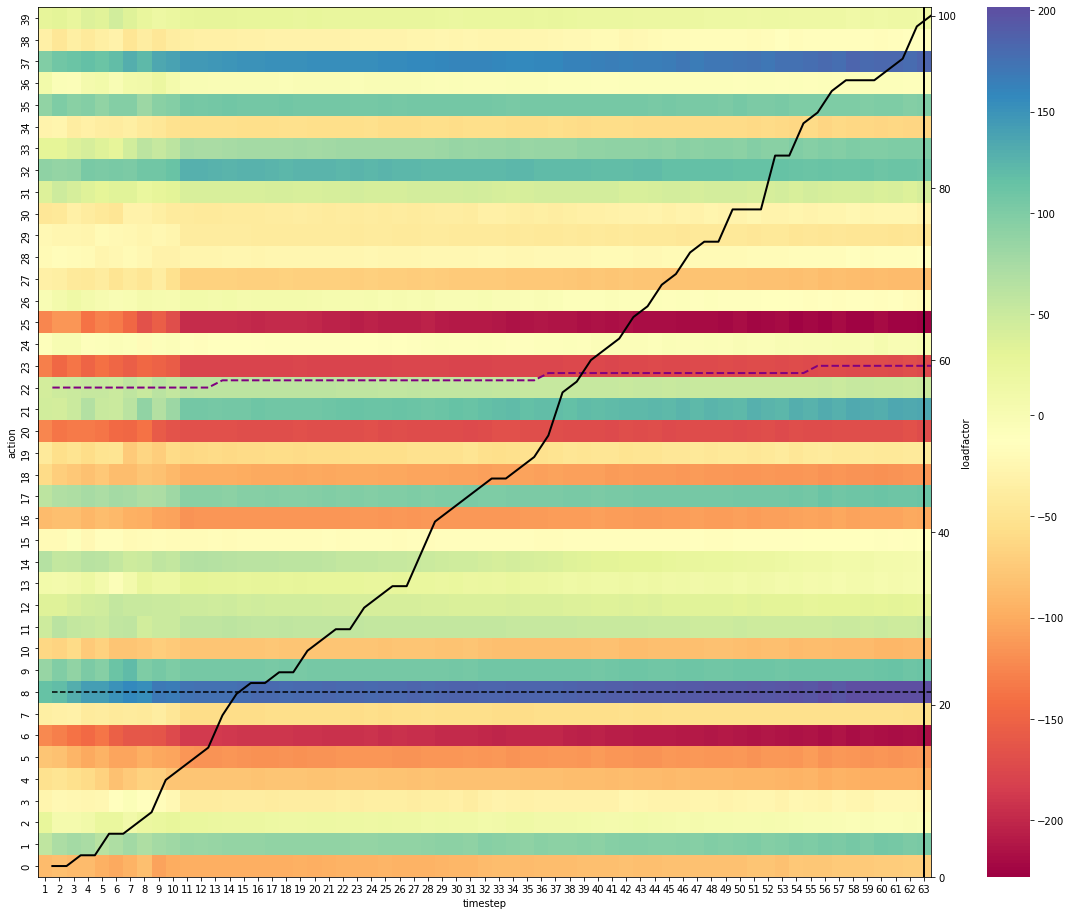

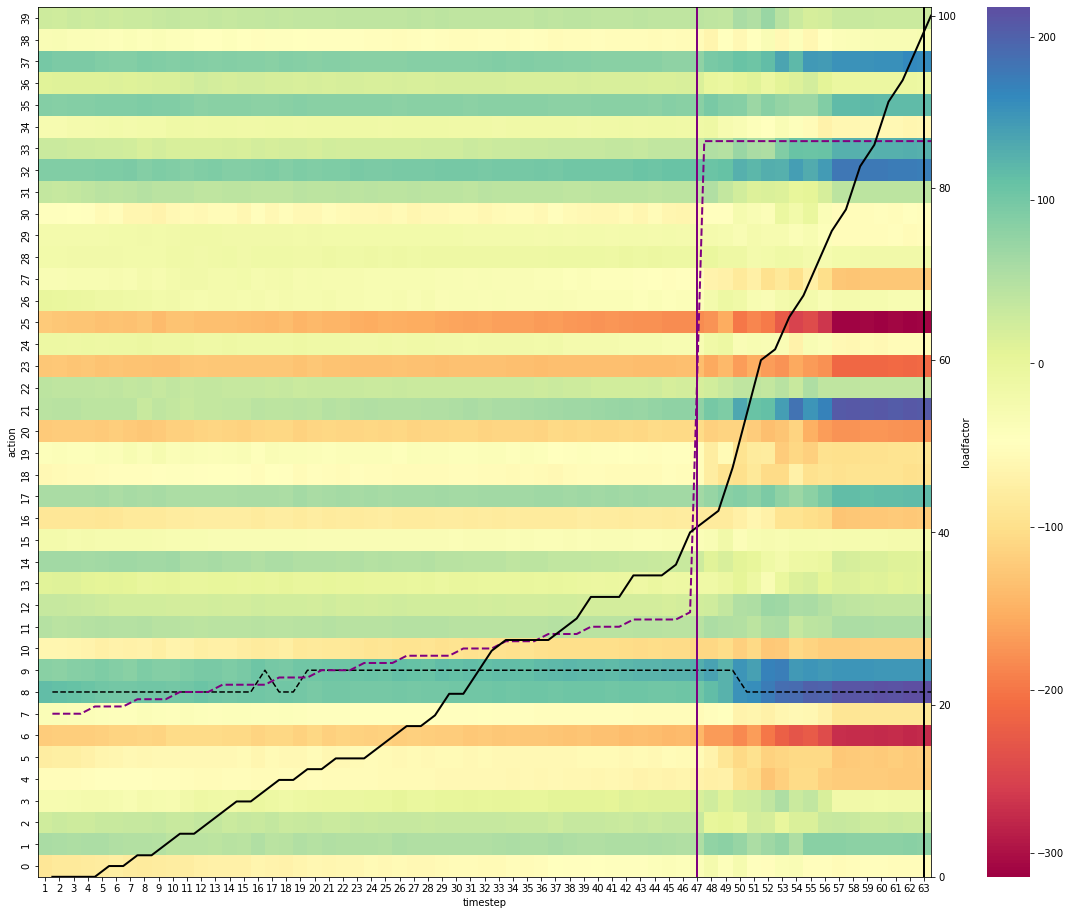

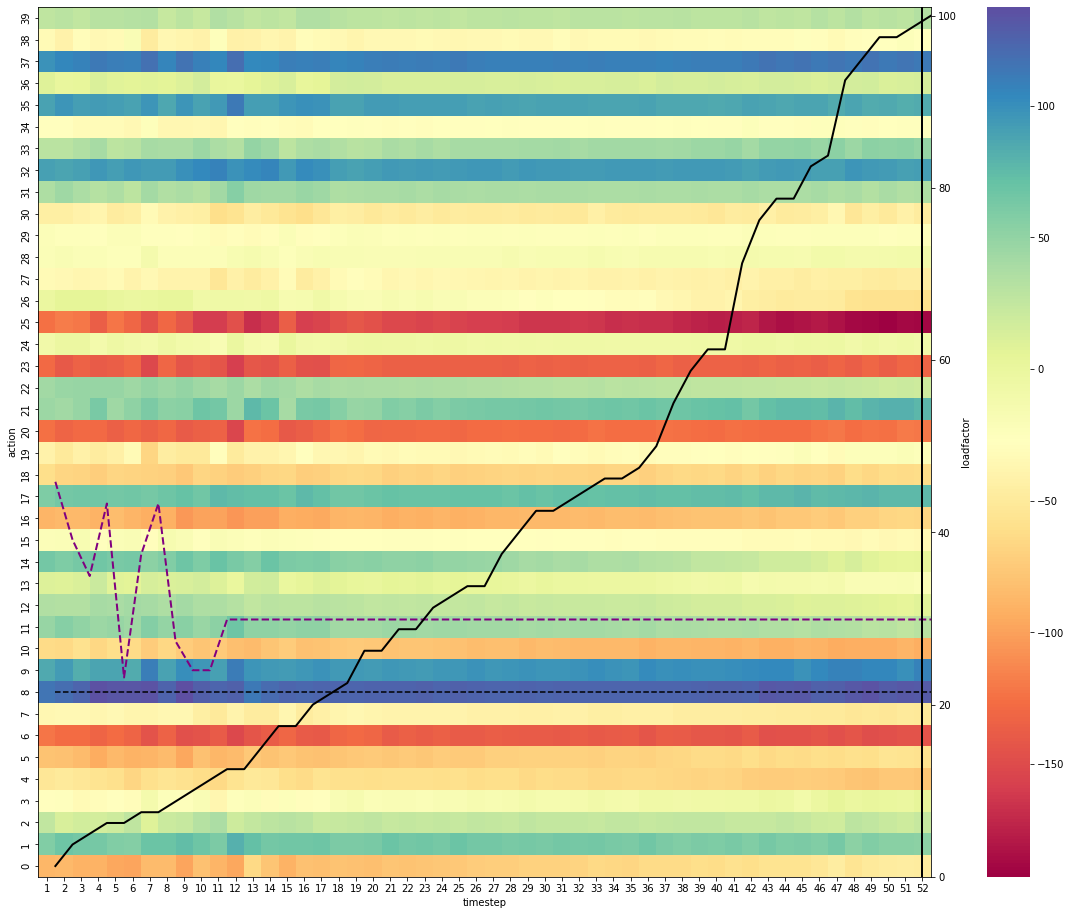

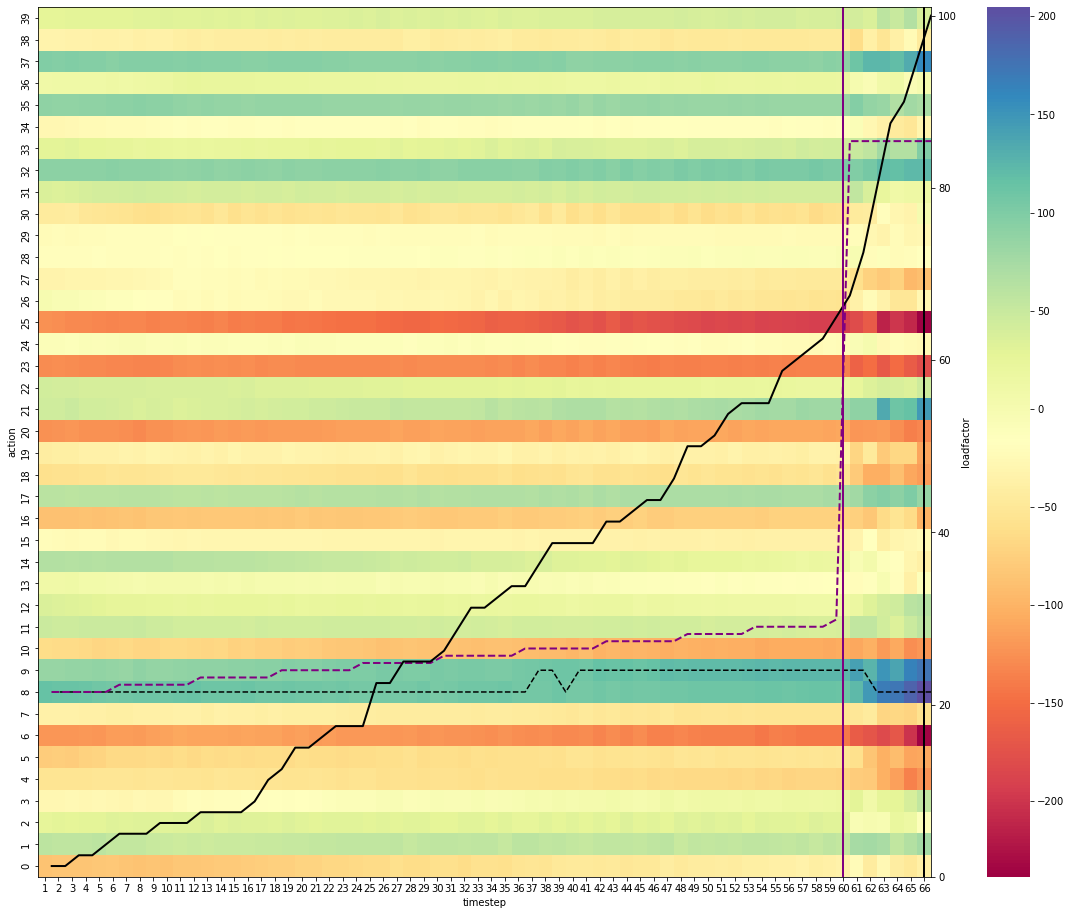

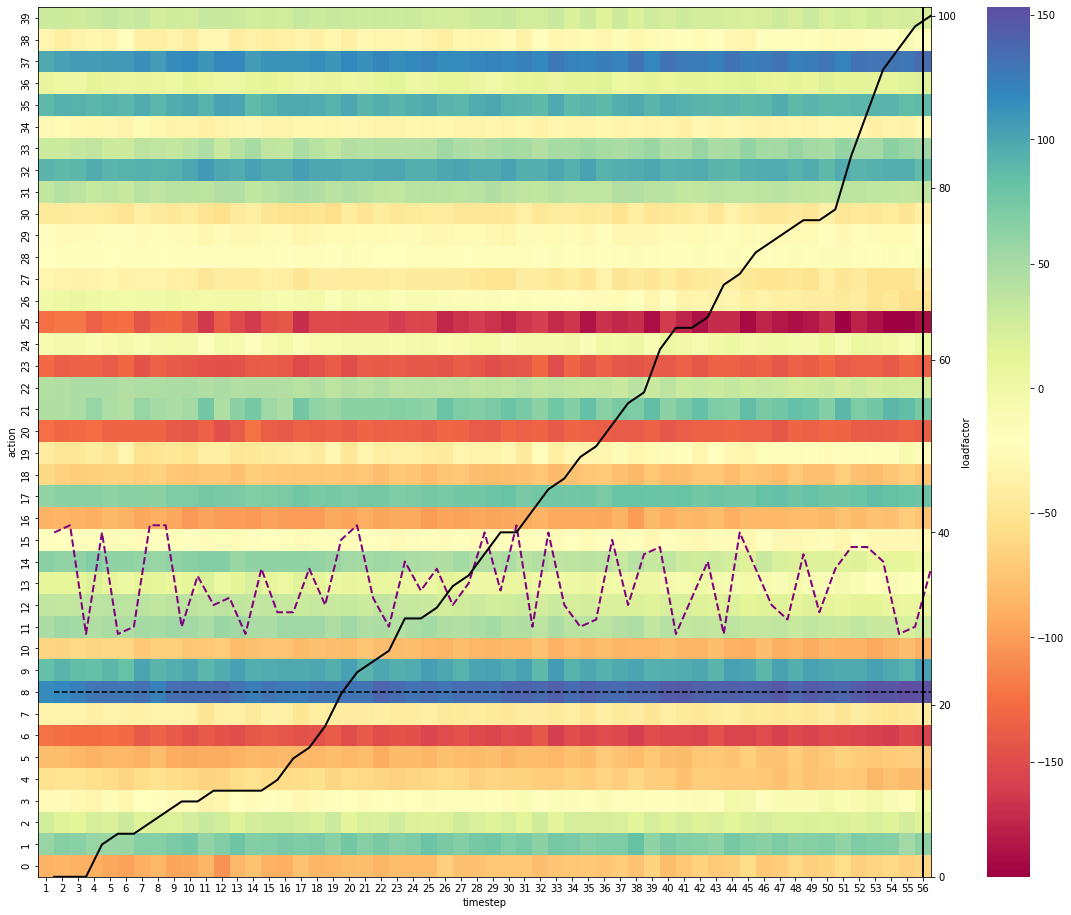

In [13]:
all_train_loss = []
all_metrics = []

run=None

# Plot for untrained model
for i in range(5):
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, 0, i, run)

In [ ]:
train_agent(1000 * 100, train_policy)

In [ ]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, run)

In [ ]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, dpc_game, i+1, i, run)

In [ ]:
for i in range(5):
    latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-6:-1]
    selling_season = latest_comp_results[i]
    competition_id = f'dqnagent{str(int(selling_season))}'

    plot_price_and_loadfactor(dpc_game.competition_results_df, competition_id, selling_season, run)

In [ ]:
train_agent(2000 * 100, train_policy)

In [ ]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [ ]:
train_agent(5000 * 100, train_policy)

In [ ]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [ ]:
train_agent(5000 * 100, train_policy)

In [ ]:
for i in range(5):
        
    plot_qlogits_heatmap(qpolicy, eval_env, i+1, i, run)

In [14]:
logits_df = pd.DataFrame()
time_step = eval_env.reset()

i=-1
while int(time_step.step_type) < 2:
    i+=1
    distribution_step = qpolicy.distribution(time_step)
    action_step = qpolicy.action(time_step)

    state_logits = pd.DataFrame({
        'timestep': np.repeat(i+1, 40),
        'action': [x for x in range(40)],
        'logit': distribution_step.action.logits[0]
    })

    logits_df = logits_df.append(state_logits)
    time_step = eval_env.step(action_step)

qactions = logits_df.groupby('timestep').agg({'logit': 'idxmax'}).reset_index()

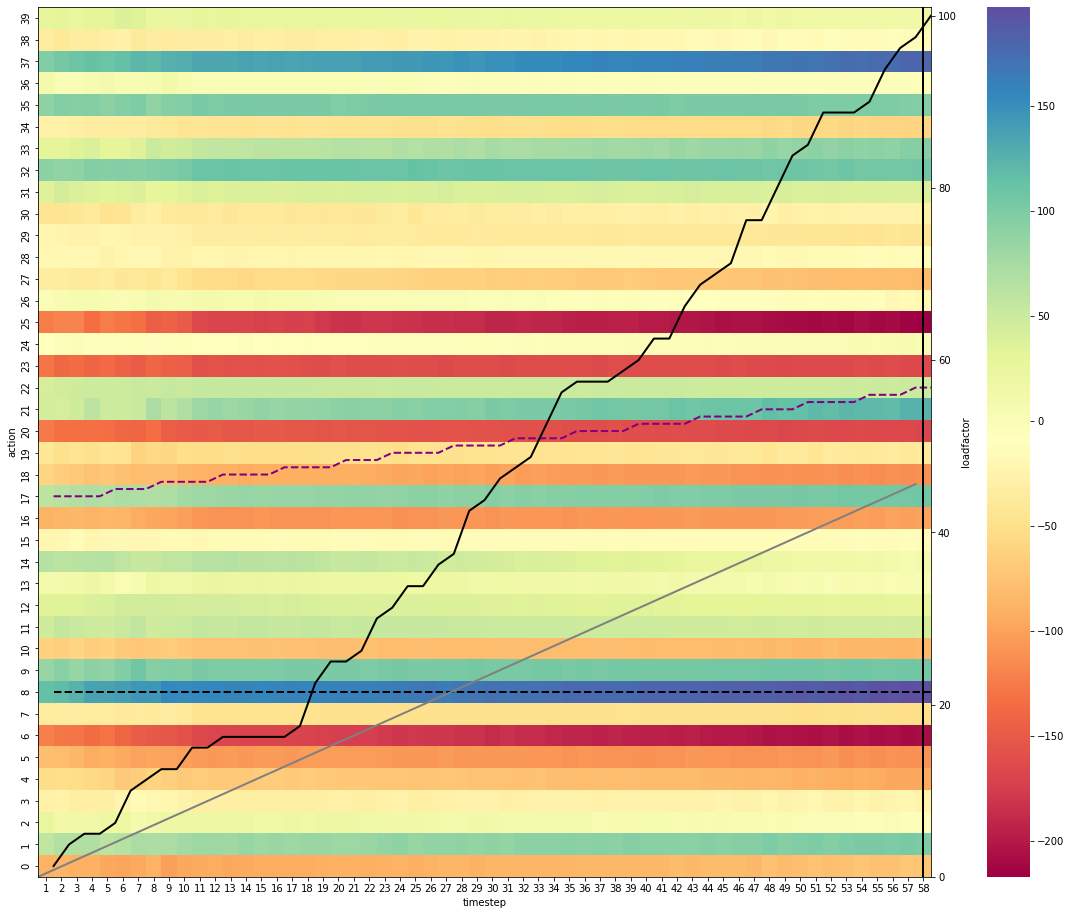

In [16]:
plt.figure(figsize=(20, 16))
ax = sns.heatmap(logits_df.pivot('action', 'timestep', 'logit'), cmap=sns.color_palette("Spectral", as_cmap=True))
sns.lineplot(x=qactions['timestep'], y=qactions['logit'] + 0.5, color='black', linestyle='--', linewidth=2)
ax.invert_yaxis()

latest_comp_results = dpc_game.competition_results_df['selling_season'].unique()[-1]
selling_season = latest_comp_results
competition_id = f'dqnagent{str(int(selling_season))}'

# Create temp dataset for competition id and season
comp_data = dpc_game.competition_results_df[
    (dpc_game.competition_results_df['selling_season'] == selling_season) & 
    (dpc_game.competition_results_df['competition_id'] == competition_id)
].reset_index(drop=True)
comp_data['loadfactor'] = comp_data['demand'].cumsum() / 80 * 100

sns.lineplot(x=comp_data['selling_period'], y=(comp_data['price_competitor'].astype(int) -20) / 3 + 0.5, 
             color='purple', linestyle='--', linewidth=2)

ax2 = plt.twinx()
sns.lineplot(x=comp_data['selling_period'], y=comp_data['loadfactor'], ax=ax2, color='black', linewidth=2)
sns.lineplot(x=[x for x in range(len(comp_data))], y=[x*0.8 for x in range(len(comp_data))], color='gray', linewidth=2)

ax2.set_ylim(0, 101)

# Add vertical lines where inventory sells out
if comp_data['loadfactor'].iloc[-1] == 100:
    plt.axvline(np.where(comp_data['loadfactor'] == 100)[0][0] + 0.5, 0, 39, color='black', linewidth=2)

if comp_data['competitor_has_capacity'].sum() < 100:
    plt.axvline(comp_data['competitor_has_capacity'].sum() + 0.5, 0, 39, color='purple', linewidth=2)
    


In [ ]:
comp_data

In [20]:
abs(147 - 30) * 0.5

58.5

In [18]:
abs(147 - 30)**2 * 0.25

3422.25

In [23]:
for i in range(25):
    print(abs(30+i*3 - 30)**2 * 0.1)

0.0
0.9
3.6
8.1
14.4
22.5
32.4
44.1
57.6
72.9
90.0
108.9
129.6
152.1
176.4
202.5
230.4
260.1
291.6
324.90000000000003
360.0
396.90000000000003
435.6
476.1
518.4


In [30]:
for i in range(25):
    print(abs(30+i*3 - 30)**2 * 0.2)

0.0
1.8
7.2
16.2
28.8
45.0
64.8
88.2
115.2
145.8
180.0
217.8
259.2
304.2
352.8
405.0
460.8
520.2
583.2
649.8000000000001
720.0
793.8000000000001
871.2
952.2
1036.8


In [32]:
for i in range(25):
    print(abs(40-i - 40)**2 * 0.05)

0.0
0.05
0.2
0.45
0.8
1.25
1.8
2.45
3.2
4.05
5.0
6.050000000000001
7.2
8.450000000000001
9.8
11.25
12.8
14.450000000000001
16.2
18.05
20.0
22.05
24.200000000000003
26.450000000000003
28.8


In [33]:
for i in range(25):
    print(abs(40-i - 40)**2 * 0.4)

0.0
0.4
1.6
3.6
6.4
10.0
14.4
19.6
25.6
32.4
40.0
48.400000000000006
57.6
67.60000000000001
78.4
90.0
102.4
115.60000000000001
129.6
144.4
160.0
176.4
193.60000000000002
211.60000000000002
230.4


In [34]:
time_step = None
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)

In [36]:
time_step, policy_state = collect_driver.run(time_step, policy_state)
time_step, policy_state

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 44), dtype=int32, numpy=
 array([[ 1,  0,  0,  1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50, 50,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>}),
 ())

In [37]:
trajectories, buffer_info = next(iterator)
trajectories

Trajectory(
{'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
array([[26, 26],
       [24, 24],
       [14, 14],
       [11, 12],
       [24, 24],
       [ 9,  9],
       [26, 26],
       [25, 25],
       [21, 21],
       [19, 19],
       [ 5,  5],
       [24, 24],
       [24, 24],
       [ 9,  9],
       [25, 25],
       [16, 16],
       [18, 18],
       [23, 24],
       [26, 27],
       [18, 18],
       [19, 19],
       [21, 22],
       [21, 21],
       [24, 24],
       [ 6, 12],
       [27, 27],
       [15, 15],
       [13, 14],
       [21, 21],
       [24, 24],
       [ 7,  7],
       [25, 25],
       [ 7,  7],
       [20, 20],
       [ 7,  7],
       [11, 11],
       [24, 24],
       [17, 17],
       [16, 16],
       [15, 15],
       [11, 11],
       [20, 20],
       [24, 24],
       [16, 16],
       [19, 19],
       [16, 16],
       [17, 17],
       [19, 19],
       [ 6,  6],
       [12, 12],
       [12, 12],
       [18, 18],
       [13, 13],
       [15, 15],
       [13, 

In [38]:
train_loss = agent.train(trajectories)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


In [39]:
start = datetime.datetime.now()

for iteration in range(100):
    current_metrics = []

    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buffer_info = next(iterator)

    train_loss = agent.train(trajectories)
    all_train_loss.append(train_loss.loss.numpy())
    
print(datetime.datetime.now() - start)

0:00:00.919373


In [40]:
start = datetime.datetime.now()

for iteration in range(1000):
    current_metrics = []

    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buffer_info = next(iterator)

    train_loss = agent.train(trajectories)
    all_train_loss.append(train_loss.loss.numpy())
    
print(datetime.datetime.now() - start)

0:00:09.054830


In [41]:
9 / 1000

0.009

In [46]:
time_step = train_env.reset()
policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
iterator = iter(dataset)

In [47]:
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 44), dtype=int32, numpy=
array([[ 1,  0,  0,  1, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
        50, 50, 50, 50, 50, 50, 50, 50,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>})

In [43]:
policy_state

()

In [48]:
action_step = qpolicy.action(time_step)

In [51]:
int(action_step.action)

7

In [52]:
30 + int(action_step.action) * 3

51

In [53]:
time_step = eval_env.step(action_step)

In [55]:
time_step

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 44), dtype=int32, numpy=
array([[ 2,  2,  2,  1, 62, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 50,
        50, 50, 50, 50, 50, 50, 50, 50,  2,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1]])>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([101.71], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>})